CNN pytorch

In [9]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

import os
print(os.listdir("./data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [10]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU...')
else:
    print('Training on GPU...')

Training on CPU...


In [11]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [12]:
BATCH_SIZE = 100
VALID_SIZE = 0.15 # percentage of data for validation

transform_train = transforms.Compose([
    transforms.ToPILImage(),
   # transforms.RandomRotation(0, 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Importing data that will be used for training and validation
dataset = pd.read_csv('./data/train.csv')

# Creating datasets for training and validation
train_data = DatasetMNIST(dataset, transform=transform_train)
valid_data = DatasetMNIST(dataset, transform=transform_valid)

# Shuffling data and choosing data that will be used for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

print(f"Length train: {len(train_idx)}")
print(f"Length valid: {len(valid_idx)}")

Length train: 35700
Length valid: 6300


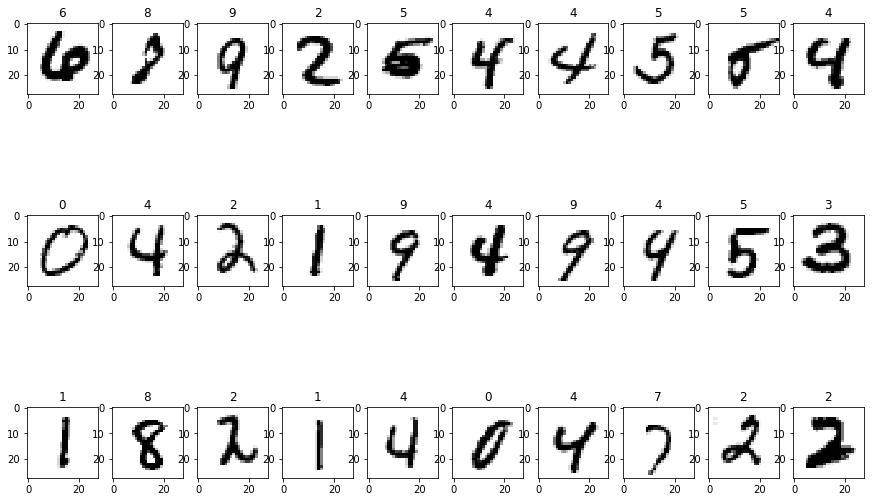

In [13]:
fig, axis = plt.subplots(3, 10, figsize=(15, 10))
images, labels = next(iter(train_loader))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]

        ax.imshow(image.view(28, 28), cmap='binary') # add image
        ax.set(title = f"{label}") # add label

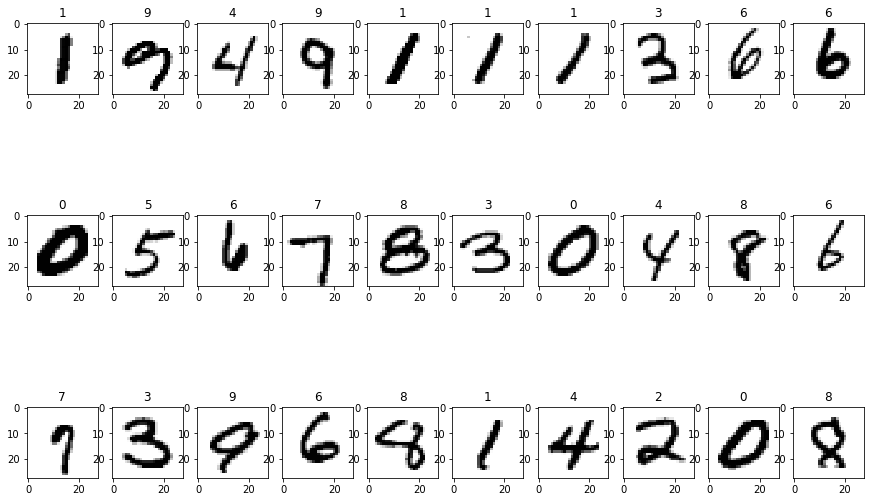

In [14]:
# Viewing data examples used for validation
fig, axis = plt.subplots(3, 10, figsize=(15, 10))
images, labels = next(iter(valid_loader))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]

        ax.imshow(image.view(28, 28), cmap='binary') # add image
        ax.set(title = f"{label}") # add label

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

In [16]:
LEARNING_RATE = 0.001680

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [17]:
epochs = 150
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = model(images)

        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            model.eval() # change the network to evaluation mode
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = model(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        history_accuracy.append(accuracy/len(valid_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model_mtl_mnist.pt')
            print('Detected network improvement, saving current model')

Epoch: 1/150..  Training Loss: 1.434..  Validation Loss: 0.528..  Test Accuracy: 0.869
Detected network improvement, saving current model
Epoch: 2/150..  Training Loss: 0.593..  Validation Loss: 0.284..  Test Accuracy: 0.921
Detected network improvement, saving current model
Epoch: 3/150..  Training Loss: 0.394..  Validation Loss: 0.203..  Test Accuracy: 0.940
Detected network improvement, saving current model
Epoch: 4/150..  Training Loss: 0.308..  Validation Loss: 0.162..  Test Accuracy: 0.951
Detected network improvement, saving current model
Epoch: 5/150..  Training Loss: 0.253..  Validation Loss: 0.137..  Test Accuracy: 0.956
Detected network improvement, saving current model
Epoch: 6/150..  Training Loss: 0.221..  Validation Loss: 0.121..  Test Accuracy: 0.961
Detected network improvement, saving current model
Epoch: 7/150..  Training Loss: 0.200..  Validation Loss: 0.108..  Test Accuracy: 0.965
Detected network improvement, saving current model
Epoch: 8/150..  Training Loss: 0.1

KeyboardInterrupt: 

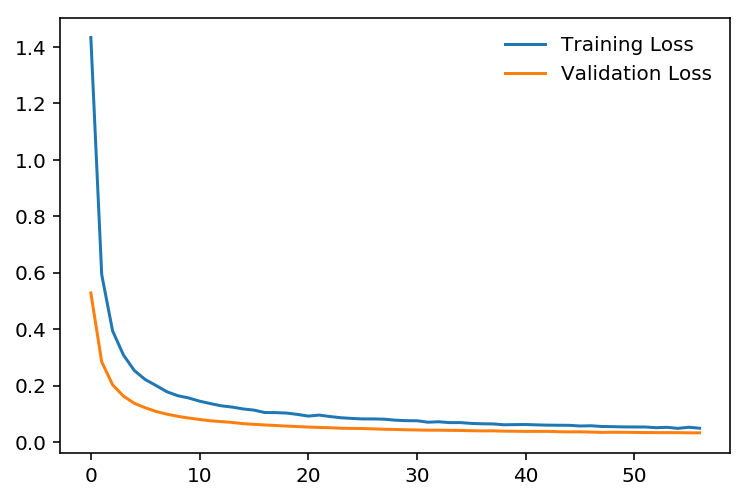

In [19]:
# Viewing training information
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)

In [18]:
model.load_state_dict(torch.load('model_mtl_mnist.pt'))

print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

In [20]:
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.4f%% (%2d/%2d)' % (
            classes[i], class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.004851

Test Accuracy of     0: 0.9922% (632/637)
Test Accuracy of     1: 0.9909% (652/658)
Test Accuracy of     2: 0.9887% (611/618)
Test Accuracy of     3: 0.9907% (640/646)
Test Accuracy of     4: 0.9870% (607/615)
Test Accuracy of     5: 0.9947% (561/564)
Test Accuracy of     6: 0.9907% (642/648)
Test Accuracy of     7: 0.9924% (651/656)
Test Accuracy of     8: 0.9875% (630/638)
Test Accuracy of     9: 0.9903% (614/620)

Test Accuracy (Overall): 99.05% (6240/6300)


In [21]:
class DatasetSubmissionMNIST(torch.utils.data.Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data.iloc[index].values.astype(np.uint8).reshape((28, 28, 1))

        
        if self.transform is not None:
            image = self.transform(image)
            
        return image

In [22]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

submissionset = DatasetSubmissionMNIST('./data/test.csv', transform=transform)
submissionloader = torch.utils.data.DataLoader(submissionset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
submission = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1

    for images in submissionloader:
        if train_on_gpu:
            images = images.cuda()
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1
            
print(len(submission) - 1)

28000


In [24]:
import csv

with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('Submission Complete!')

Submission Complete!
